In [2]:
#Import Library
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
#Download Resource NLTK
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\A S U
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\A S U
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#Load Dataset
df = pd.read_csv("dataset_valorant.csv")
df.head()


,komentar
0,entry frag gagal total
1,aim gue hari ini on point
2,entry frag gagal total
3,clutch barusan bikin merinding
4,matchmaking valorant kadang ga adil


In [5]:
#Case Folding & Cleaning Dasar

def clean_text(text):
    text = text.lower()                               # huruf kecil
    text = re.sub(r'(.)\1{2,}', r'\1', text)          # huruf berulang
    text = re.sub(r'\d+', '', text)                   # angka
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [6]:
#Stopword & Stemming

stopwords_indo = set(stopwords.words('indonesian'))

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess(text):
    text = text.lower()

    # hapus url & angka
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', '', text)

    # hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))

    # normalisasi huruf berulang
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    tokens = word_tokenize(text)

    # JANGAN buang kata pendek (mie, pas, enak)
    tokens = [t for t in tokens if len(t) >= 2]

    # stopword ringan
    tokens = [t for t in tokens if t not in stopwords_indo]

    # stemming ringan
    tokens = [stemmer.stem(t) for t in tokens]

    return ' '.join(tokens)



In [7]:
#Terapkan Preprocessing ke Dataset
df['clean_text'] = df.iloc[:, 0].astype(str).apply(preprocess)
df.head()


,komentar,clean_text
0,entry frag gagal total,entry frag gagal total
1,aim gue hari ini on point,aim gue on point
2,entry frag gagal total,entry frag gagal total
3,clutch barusan bikin merinding,clutch barusan bikin merinding
4,matchmaking valorant kadang ga adil,matchmaking valorant kadang ga adil


In [8]:
df['clean_text'].str.split().str.len().describe()


count    7680.000000
mean        4.916797
std         1.329141
min         2.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         7.000000
Name: clean_text, dtype: float64

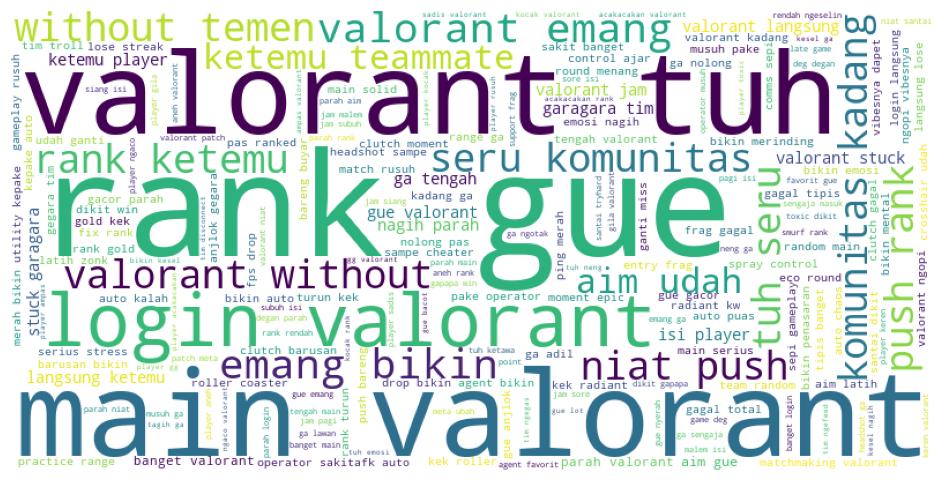

In [9]:
#WordCloud Seluruh Data
df_wc = df[df['clean_text'].str.strip() != '']
all_text = ' '.join(df_wc['clean_text'])

if all_text.strip() == "":
    print("⚠️ Tidak ada kata untuk WordCloud")
else:
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(all_text)

    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()



In [10]:
#Pelabelan Sentimen (Rule-Based)
positive_words = ['bagus','mantap','keren','hebat','puas','senang']
negative_words = ['jelek','buruk','kecewa','parah','sedih','benci']

def label_sentiment(text):
    score = 0
    for p in positive_words:
        if p in text:
            score += 1
    for n in negative_words:
        if n in text:
            score -= 1

    if score > 0:
        return 'Positif'
    elif score < 0:
        return 'Negatif'
    else:
        return 'Netral'

df['sentiment'] = df['clean_text'].apply(label_sentiment)
df[['clean_text','sentiment']].head()


,clean_text,sentiment
0,entry frag gagal total,Netral
1,aim gue on point,Netral
2,entry frag gagal total,Netral
3,clutch barusan bikin merinding,Netral
4,matchmaking valorant kadang ga adil,Netral


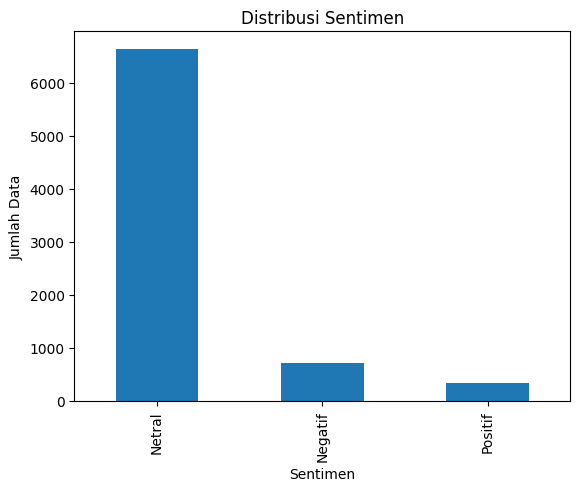

In [11]:
#Distribusi Sentimen
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')
plt.show()


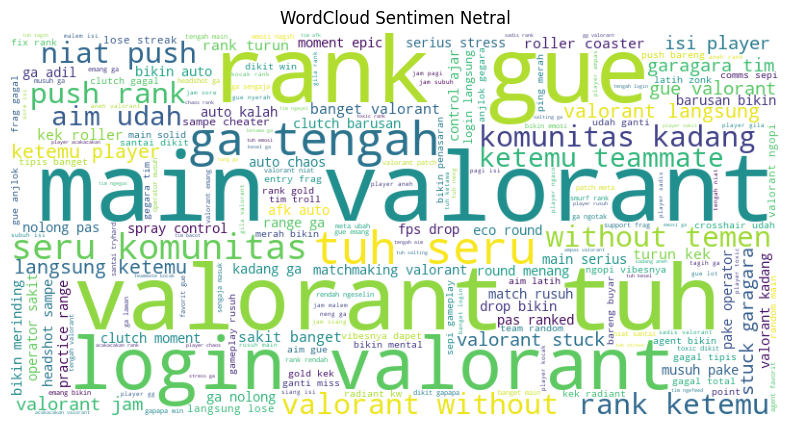

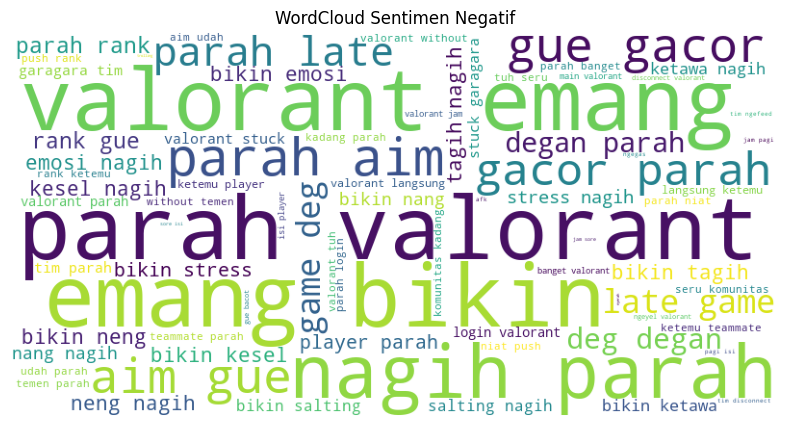

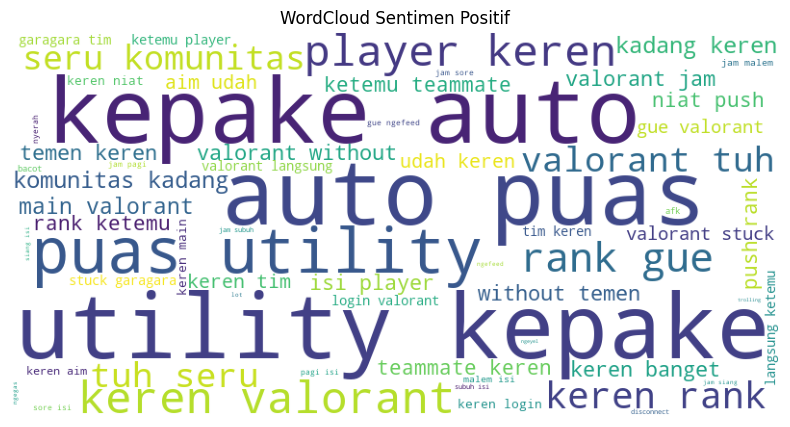

In [12]:
#WordCloud per Sentimen
for s in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment'] == s]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.title(f'WordCloud Sentimen {s}')
    plt.axis('off')
    plt.show()


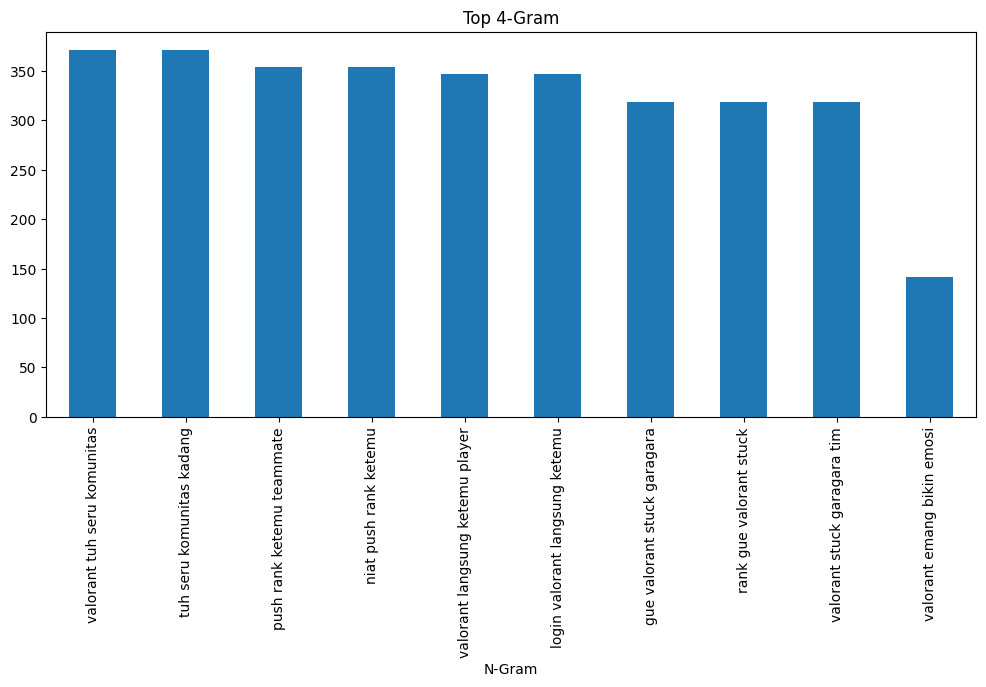

In [13]:
#N-Gram (4-Gram)
vectorizer = CountVectorizer(ngram_range=(4,4), max_features=10)
X = vectorizer.fit_transform(df['clean_text'])

ngram_freq = X.sum(axis=0)
ngrams = vectorizer.get_feature_names_out()

ngram_df = pd.DataFrame({
    'N-Gram': ngrams,
    'Frekuensi': ngram_freq.A1
}).sort_values(by='Frekuensi', ascending=False)

ngram_df.plot(
    x='N-Gram',
    y='Frekuensi',
    kind='bar',
    legend=False,
    figsize=(12,5)
)
plt.title('Top 4-Gram')
plt.show()
